![Samples of TFIM](figs/SetOfSamples.png)


# <span style="color:darkslategray">  Tutorial on Reconstructing Quantum States with Positive-Operator Valued Measurements (POVMs) and Recurrent Neural Networks </span>



Michael Albergo

A walkthrough of using Pepinillo to reproduce results from https://arxiv.org/pdf/1810.10584.pdf by Juan Carrasquilla, Giacomo Torlai, Roger Melko, and Leandro Aolita.



RNN Model includes sampler, used later for visualization. Hyperparameters defined in cell 3 other than learning rate

In [2]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import os
import datetime
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import palettable
import seaborn as sns

# <span style="color:steelblue"> Setting the Scenario </span>

Imagine you are trying to prepare a 50-qubit quantum system that is governed by the Transverse-Field Ising Model 1D  Hamiltonian: 
<img src="figs/TransverIsingModel1DHamiltonian.png" alt="TFIMHamiltonian" width="300"/>

You want to be able to check on the fidelity of your setup to verify that you have properly prepared the quantum state. To do this, you want to perform inference on the density matrix of the mixed state -- to show that informationally complete measurement samples from your setup match the expected frequency associated with your intended density matrix $\rho$. With the right choice of measurements -- namely informationally complete Postive-Operator Valued Measurements for each qubit $M = \{ M^{(\mathbf{a_i})} \otimes \dots \otimes M^{(\mathbf{a_n})} \}$, we can link the probability of measurement outcomes with the invertible expression given by Born's Rule: $P(\mathbf{a}) = \mathrm{Tr}[M^{(\mathbf{a})}\rho]$. Thus, if we can gain insight into the distribution of measurement ourcomes $P(\mathbf{a})$, we can gain insight into the density matrix $\rho$. Here, each $a_i$ in $\mathbf{a}$ can take on a discrete value to represent the measurement outcome for the $i^{th}$ qubit. The number of possible outcomes is decided by which POVM measurements are used.


## <span style="color:steelblue">How do we learn $P(\mathbf{a})$? Recurrent Neural Networks </span>

Modern machine learning methods offer a variety of methods for learning some generative distribution $p(x)$. In this tutorial, we treat our qubit measurements as sequential measurements (though the order is arbitrary) and apply a recurrent neural network model made of 2 linked gated recurrent units (GRUs). I'll explain these a bit below.

In a generative recurrent model, we can represent the joint ditribution $p(\mathbf{a})$ over all N qubit measurement outcomes by factorizing it according to the chain rule:

\begin{equation} p(\mathbf{a}) = p(a_1) p(a_2 | a_1) p(a_3 | a_1, a_2)...p(a_N | a_1, \dots, a_{N-1})\end{equation}

The idea here is to make estimates of each of these factors sequentially with subsequent passes through the recurrent unit. An RNN is composed of some fundamental cell, which is some weight matrix or set of weight matrices that are fixed after training and a hidden state $h_t$ whose value is updated at each sequential step.

This is visualized in the diagram below. 

<img src="figs/RNNUnit.jpg" alt="RNN" width="500"/>

At the first step $t = 0$, we feed in some fixed initial $h_0$, $x_0$ of arbitrary value. The output of the RNN at the first time sequence is a probability distribution over measurement outcomes for the first qubit and an update to the hidden state $h_t$. 


What exactly are the measurement outcomes? In this tutorial, they are the set of Pauli-4 POVMs: 

In this setup, we one-hot encode the potential measurement outcomes so each measurement outcome 0,1,2,3 is associated with a vector of dimension 4. For example, outcome 0 would be [1,0,0,0], outcome 1 would be [0,1,0,0]. 

SHOW DIAGRAM OF RNN and specifically GRU, explain how probability measures over one-hot vectors are calculated at each time step and passed forward through the RNN again with different h_t. In this setup, we one-hot encode the potential measurement outcomes so each measurement outcome 0,1,2,3 is associated with a vector of dimension 4. For example, outcome 0 would be [1,0,0,0], outcome 1 would be [0,1,0,0]

Pauli-4 TFIM data. Datafile is named "numpy_POVM_data.npz"

In [3]:
device = torch.device("cpu" if torch.cuda.device_count() != 0 else "cpu")
print(device)

n_qubits = 50
n_outcomes =4
batchSize =100
hidden_size = 100
num_gru_layers = 3
num_epochs = 50
log_interval = 50
loss_by_step = True
lr = 0.001

cpu


#### Load the data

In [4]:


data_array = np.load('data/TFIM_training_data.npz')['data']
log_probs = np.load('data/TFIM_logprobs.npz')['probs']
#print(data_array.shape)

In [5]:

print(data_array.shape, log_probs[:10])

(2040000, 200) [-56.01225927 -46.36874892 -52.53915542 -55.4978294  -59.29920549
 -46.27205902 -55.19172129 -50.66383047 -41.72386322 -42.75729036]


#### Reshape it to batch it for Pytorch dataloader

(n_samples, n_qubits, n_outcomes) ----> (n_samples, 50, 4) in this case

In [6]:

reshaped_array = np.empty((data_array.shape[0], 50, 4))
for i in range(data_array.shape[0]):
    reshaped_array[i] = data_array[i].reshape((50,4))


#### Load the data

In [7]:
# I LOAD THE DATA INTO A PYTORCH DATALOADER CLASS

tensor_array_train = torch.stack([torch.Tensor(i).double() for i in reshaped_array[:10000]])
tensor_data_train = torch.utils.data.TensorDataset(tensor_array_train)
tensor_array_test = torch.stack([torch.Tensor(i).double() for i in reshaped_array[10000:20000]])
tensor_data_test = torch.utils.data.TensorDataset(tensor_array_test)

train_loader = torch.utils.data.DataLoader(tensor_data_train, batch_size=batchSize, num_workers=1)
test_loader = torch.utils.data.DataLoader(tensor_data_test, batch_size = batchSize, num_workers = 1)
print(train_loader)

#### Compute the Classical Fidelity $F_c$  and the KL-divergence $\mathrm{KL}$ between  $P_{RNN}$ and $P_{TFIM}$

\begin{equation} \begin{split} F_c &= \sum_i \sqrt{P_{RNN}(i) \quad P_{TFIM}(i)}  \\ & \approx \frac{1}{N_s} \sum_i e^{\frac{1}{2} ( \log P_{RNN}(i) - \log P_{TFIM}(i))}\end{split} \end{equation} 


------------------

\begin{equation} \begin{split} \mathrm{KL} & = \sum_i P_{TFIM}(i) \log{\frac{P_{TFIM}(i)}{P_{RNN}(i)}} \\ & \approx \frac{1}{N_s} \sum_i ( P_{TFIM}(i) - P_{RNN}(i))\end{split} \end{equation} 


In [8]:
# KL, Fidelity function

def compute_KL_CF(model, real_data = reshaped_array, logPs = log_probs, num_samples = 150, num_layers = num_gru_layers):

    KL = 0
    fidelity = 0
    for batch_idx, (data) in enumerate(train_loader,):
        data = data[0].to(device).permute(1,0,2)
        
        hidden, outcome_probs, loss, inputX = model(data)
        logq_batch = (torch.sum(torch.log(torch.sum(outcome_probs * data, dim=2)), dim=0))
        KL += np.sum(logPs[(batch_idx*batchSize):(batch_idx*batchSize + batchSize)] - logq_batch.cpu().data.numpy())
        fidelity += np.sum(np.exp((1/2) * (logq_batch.cpu().data.numpy() - logPs[(batch_idx*batchSize):(batch_idx*batchSize + batchSize)] )))
        
        if batch_idx == 25:
            break
    
    KL = KL / (batchSize * batch_idx)
    
    fidelity = fidelity / (batchSize*batch_idx)
       
    return KL, fidelity

#kl, fidelity = compute_KL(model)  

#### Build the RNN model, loss function, and sampling function 

In [9]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import os
import datetime
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

device = torch.device("cpu")
#loss_by_step = False



class GRUunit(nn.Module):
    def __init__(self, n_outcomes, hidden_size, input_size, bias=True, last = False):
        super(GRUunit, self).__init__()
        self.n_outcomes = n_outcomes
        self.hidden_size = hidden_size
        self.bias = bias
        self.Wz = nn.Linear(input_size, hidden_size, bias=bias)
        self.Wr = nn.Linear(input_size, hidden_size, bias=bias)
        self.W = nn.Linear(input_size, hidden_size, bias=bias)
        self.fc = nn.Linear(hidden_size, n_outcomes)
        self.last = last
        

        
    def forward(self, x, hidden):
        
        #x = x.view(-1, x.size(1))
        
        z_t = torch.sigmoid(self.Wz(torch.cat((hidden,x),dim=2))) 
        r_t = torch.sigmoid(self.Wr(torch.cat((hidden,x),dim=2)))
        
        #z_t = z_t.squeeze()
        #r_t = r_t.squeeze()

        h_tilde = torch.tanh(self.W(torch.cat((r_t * hidden , x), dim=2 )))
        
        
        h_new = (1 - z_t) * hidden + (z_t*h_tilde)
        
        if self.last == True:
            probs = torch.softmax(self.fc(h_new) , dim = 2)
        else:
            probs = h_new
        
        return h_new, probs
    
    
class GRUModel(nn.Module):
    def __init__(self, n_outcomes, hidden_dim, bias=True):
        super(GRUModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        self.n_outcomes = n_outcomes
        self.loss_by_step = loss_by_step
        self.batchSize = batchSize
        self.init_z = torch.nn.Parameter(torch.randn(1,self.batchSize, 10))
        
         
         
        self.gru1 = GRUunit(self.n_outcomes, self.hidden_dim, self.n_outcomes + self.hidden_dim + 10)
        self.gru2 = GRUunit(self.n_outcomes, self.hidden_dim, self.hidden_dim + self.hidden_dim, last=False)
        self.gru3 = GRUunit(self.n_outcomes, self.hidden_dim, self.hidden_dim + self.hidden_dim, last=True)
        self.fcz = nn.Linear(10 + self.n_outcomes, 10 + self.n_outcomes)

    def step(self, input, hidden):
        hn1, outcome_probs1 = self.gru1(torch.relu(self.fcz(torch.cat((self.init_z,input),dim=2))), hidden[0].unsqueeze(0))
        hn1 = torch.relu(hn1)
        hn2, outcome_probs2 = self.gru2(outcome_probs1, hidden[1].unsqueeze(0))
        hn2 = torch.relu(hn2)
        hn3, outcome_probs3 = self.gru3(outcome_probs2, hidden[2].unsqueeze(0)) 
            
        #outs.append(hn3)
        #outcome_prob
        #print(hn2.shape)
        return torch.cat((hn1,hn2, hn3),dim=0), outcome_probs3
    
    def initHidden(self):
        '''
        must be shape 
        [self.num_layers * num_directions (1 in this case), batchSize, hidden_size]
        '''
        return torch.zeros(3, batchSize, self.hidden_dim).to(device).double()
    
    def init_q0(self):
        '''
        must be shape 
        [(1 step), batchSize, hidden_size]
        '''
        return torch.zeros(1, batchSize, self.n_outcomes).to(device).double()
    
    def myCrossEntropyLoss(self, outputs, labels):
        #batch_size = outputs.size()[0]            # batch_size
        outputs = torch.log(outputs)   # compute the log of softmax values
        outputs = outputs[range(self.batchSize), labels] # pick the values corresponding to the labels
        #print(outputs.shape)
        return -torch.sum(outputs)/self.batchSize
     
    
    def forward(self, inputs):

        outcome_probs = torch.zeros(inputs.size(0), batchSize, n_outcomes).double().to(device)
        losses = torch.zeros(inputs.size(0), batchSize)
    
        for i in range(inputs.size(0)):
            optimizer.zero_grad()
            if  i == 0:
                hidden = self.initHidden()
                inp = self.init_q0()
                #print(hidden.shape, inp.shape)
                inputX = inp
                #print(inputs[i].shape)
                targets = torch.argmax(inputs[i],dim=1)
                
            else:
                inp = inputs[i-1,:,:].unsqueeze(0)
                targets = torch.argmax(inputs[i],dim=1)
  
            hidden, outcome = self.step(inp, hidden)

            #outputs[i] = output
            outcome_probs[i] = outcome
            
            # Calculate loss per step
            if self.loss_by_step == True:
              #  print(outcome.shape, targets.shape)
                loss_i = self.myCrossEntropyLoss(outcome.squeeze(), targets)
                losses[i,:] = loss_i
                
            if loss_by_step == False:
                losses = self.loss(inputs, outcome_probs)
        
            
            loss_i.backward(retain_graph=True)
            optimizer.step()
        loss = torch.sum(losses)
        return hidden, outcome_probs, loss, inputX
    
    
    def sample(self):

        hidden = self.initHidden()
        inputX = self.init_q0()
        #print(hidden.shape)

        # one hot encoded for each qubit
        samples = torch.zeros(50, self.batchSize, self.n_outcomes)
        probs = torch.zeros(self.batchSize)

        for i in range(50):

            #initialize for one-hot encoding, qubit_i_samples will be a class chosen for each batch entry based on probabilities
            # batchSize number of samples for ith qubit
            qubit_i_samples = torch.zeros(self.batchSize)
            if i == 0:
                hidden, outcome = self.step(inputX, hidden)
                qubit_i_probs = outcome.to('cpu').squeeze().data.numpy()
            elif i > 0:
                hidden, outcome = self.step(input.unsqueeze(0).to(device).double(), hidden)
                qubit_i_probs = outcome.to('cpu').squeeze().data.numpy()

            for batch_entry in range(self.batchSize):
                #print(qubit_i_probs.shape)
                #print(np.random.choice([0,1], size = 1, p=qubit_i_probs[batch_entry]))
               # print(qubit_i_probs)
                #print(qubit_i_probs[batch_entry])
                qubit_i_samples[batch_entry] = torch.from_numpy(np.random.choice([0,1,2,3], size = 1, p=qubit_i_probs[batch_entry]))

            #make the one-hot samples, use to feed as next input
            samples[i][torch.arange(qubit_i_samples.shape[0]).long(), qubit_i_samples.long()] = 1
            input = samples[i]

        return samples
    

    
model = GRUModel(n_outcomes,hidden_size, bias=True).to(device).double()
optimizer = optim.Adam(model.parameters(), lr=lr)
    
    

#### Train the model

In [10]:
train_losses = []
KLs = []
fidelities = []
for epoch in range(1, num_epochs + 1):
    #train(epoch, train_losses)
    train_loss = 0
    for batch_idx, (data) in enumerate(train_loader,):
        data = data[0].to(device).permute(1,0,2)#.reshape(n_qubits, batchSize, n_outcomes)
        
        #if batch_idx == 1:
         #   print(data[:,0])
        #optimizer.zero_grad()
        hidden, outcome_probs, loss, inputX = model(data)
        #loss.backward()
        
        train_loss += loss.item()
        #optimizer.step()
        if batch_idx % log_interval == 0:
            KL, fidelity = compute_KL_CF(model)
            
            KLs.append(KL)  
            fidelities.append(fidelity)  
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batchSize, len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / batchSize))
    avg_batch_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_batch_loss)

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, avg_batch_loss))

Train Epoch: 1 [0/10000 (0%)]	Loss: 56.665918
Train Epoch: 1 [5000/10000 (50%)]	Loss: 51.668135
====> Epoch: 1 Average loss: 51.7905
Train Epoch: 2 [0/10000 (0%)]	Loss: 51.605166


Traceback (most recent call last):
  File "/Users/michaelalbergo/anaconda3/envs/pytorch1/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/michaelalbergo/anaconda3/envs/pytorch1/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/michaelalbergo/anaconda3/envs/pytorch1/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/michaelalbergo/anaconda3/envs/pytorch1/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

#### Visualize $\mathrm{KL}$ and $F_c$ over training time

[1.4932532866781334, 0.45912179545535675, 0.320482595486333] [0.7289097286146236, 0.934419544042288, 0.9677178056133882]


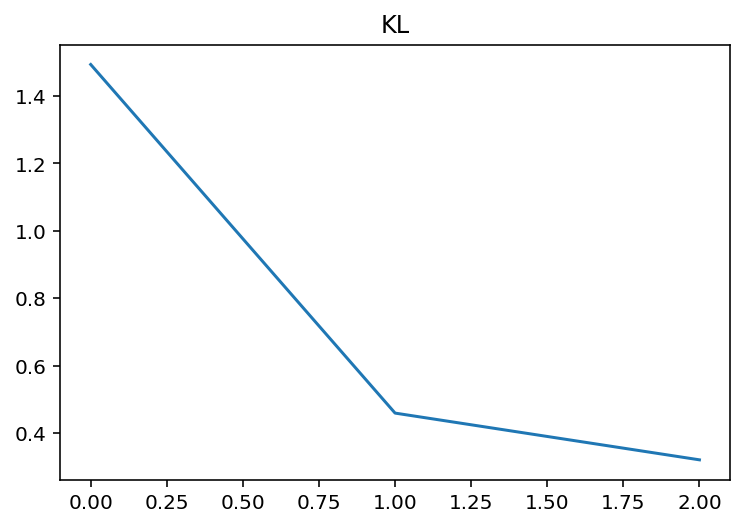

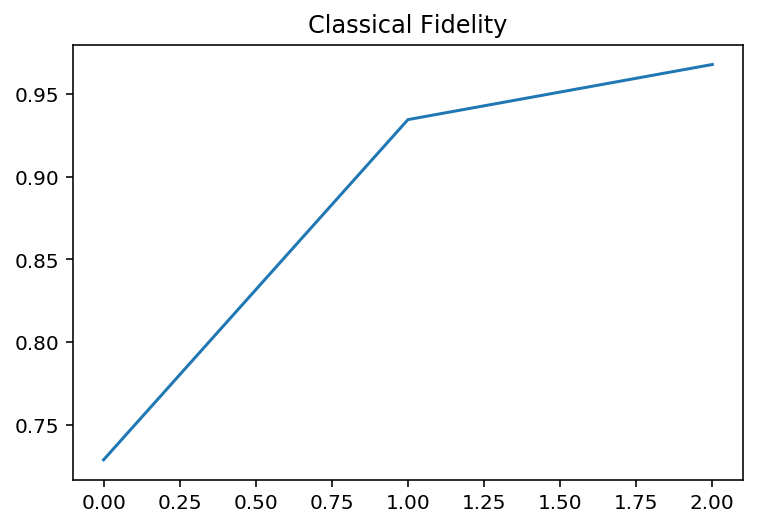

In [11]:
print(KLs, fidelities)
plt.plot(range(len(KLs)), KLs)
plt.title("KL")
plt.show()
plt.plot(range(len(KLs)), fidelities)
plt.title("Classical Fidelity")
plt.show()

## Comparing samples from the RNN and Ground Truth


Here we sample from the model and compare its distribution outcomes to the ground truth

In [42]:

sample_test = model.sample()

bin_counts = [np.bincount(np.argmax(sample_test[:,i,:].cpu().data.numpy(), axis = 1)) for i in range(batchSize) ]
print(sample_test.shape)
#print(bin_counts)
print("Real Percent distribution for 50 qubtis:", true_percentages)
print("Percent distribution for the 50 qubits:",(np.array(bin_counts).mean(0) / np.array(bin_counts).mean(0).sum()))
print("Outcome distribution for the 50 qubits:",np.array(bin_counts).mean(0))

torch.Size([50, 100, 4])
Real Percent distribution for 50 qubtis: [0.16663017 0.05579797 0.16662539 0.61094647]
Percent distribution for the 50 qubits: [0.1728 0.0518 0.16   0.6154]
Outcome distribution for the 50 qubits: [ 8.64  2.59  8.   30.77]


# Visualizing the Measurement Outcomes

We can visualize our samples by plotting the 50 qubit measurement outcomes in rows to see how they behave.

<Figure size 1080x72 with 0 Axes>

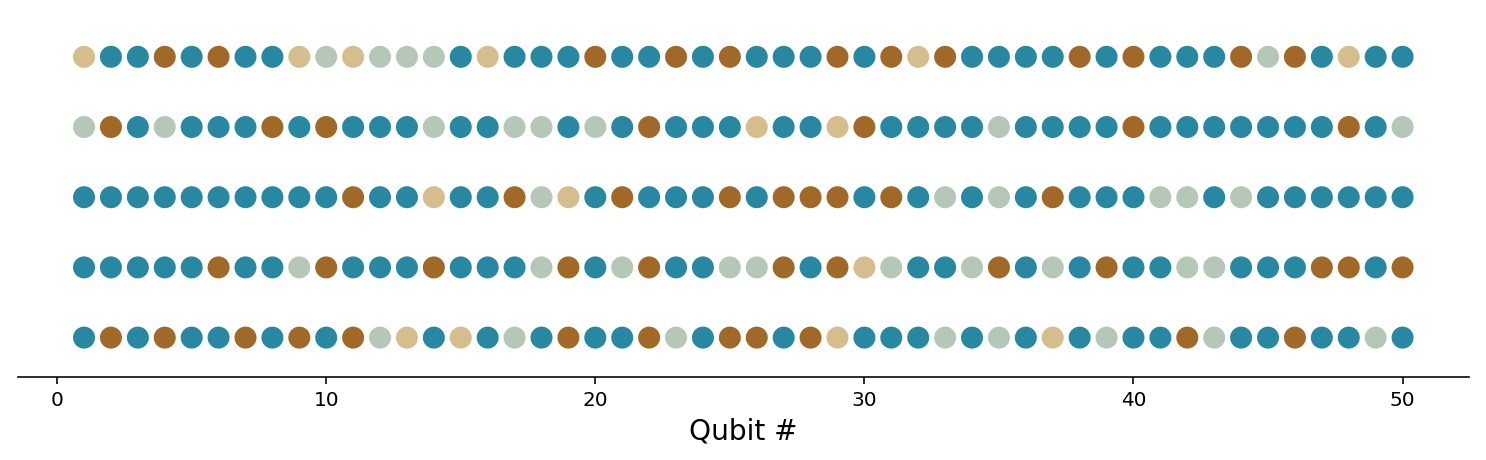

In [43]:
def plot_samples(sample_test = sample_test, n_samples = 1, n_qubits = n_qubits, batchSize=batchSize):
    
    if n_samples > batchSize:
        print("Number of samples must be less than batchSize.")
        return -1
        
    qubits = np.arange(1, n_qubits + 1)
    color_labels = np.array([np.argmax(sample_test[:,i,:].cpu().data.numpy(), axis = 1) for i in range(batchSize)])#[0.456,0.962,0.231] 
    #print(color_labels[0].shape, qubits.shape)
    #UnlabelledY=[0,1,0]
    fig = plt.figure(figsize=(15,1))
    flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
    muted=["#4878CF", "#6ACC65", "#D65F5F",
               "#B47CC7", "#C4AD66", "#77BEDB"]
    #my_cmap = ListedColormap(sns.color_palette(muted).as_hex())
    #cmap = sns.cubehelix_palette(light=0.8, dark=0.4, start=0.03, rot=0.4, as_cmap=True)
    cmap = ListedColormap(palettable.cartocolors.diverging.Earth_4.mpl_colors)
    #cmap = ListedColormap(palettable.wesanderson.Chevalier_4.mpl_colors)
    #cmap = ListedColormap(palettable.wesanderson.Darjeeling2_5.mpl_colors)
    #cmap = ListedColormap(palettable.wesanderson.Moonrise2_4.mpl_colors)
    #cmap = ListedColormap(palettable.wesanderson.FantasticFox2_5.mpl_colors)
    print(cmap)
    
    if n_samples == 1:
        fig = plt.figure(figsize=(15,1))
        plt.scatter(qubits, np.zeros_like(qubits), 
                c=color_labels[0], cmap=cmap, vmin=0, s=120)
        #plt.axis('off')
        plt.xlabel("Qubit #", fontsize=14)
    else:
        fig, axes = plt.subplots(n_samples, 1, figsize=(13,n_samples * 0.66))
        fig.subplots_adjust(hspace=-0.1)
        for i in range(n_samples):
            axes[i].scatter(qubits, np.zeros_like(qubits), 
                    c=color_labels[i], cmap=cmap, vmin=0, s=100)
            axes[i].set_yticks([])
            sns.despine(left=True, bottom=True)
            #sns.despine(bottom=True)
            #sns.despine(top=True)
            if i == n_samples - 1:
                axes[i].set_xlabel("Qubit #", fontsize=14)
                axes[i].spines["bottom"].set_visible(True)
            else:
                axes[i].set_xticks([])

    plt.show()
    return

plot_samples(sample_test = sample_test, n_samples = 5, n_qubits = 50)


In [22]:
#batchSize = 50
#batchSize = 100
index = np.random.randint(0,len(data_array))
test = reshaped_array[index:index+batchSize]
data = torch.from_numpy(test).double().to(device)
#print(data.shape)
#print(inputX.shape)
#print(hidden.shape)

#output, hidden, outcome, loss, inputX = model(data)


# THIS IS NOW INCORPORATED INTO RNN model but, keeping here for backup
def sample(model, n_qubits, batchSize = batchSize, hidden_size = hidden_size, n_outcomes = n_outcomes, num_layers = num_gru_layers):
    
    #initialize hidden as in model
    hidden = torch.ones(1*num_layers, batchSize, hidden_size).to(device).double()
    initX = torch.ones(1, batchSize, n_outcomes).to(device).double()
    samples = torch.zeros(n_qubits, batchSize, n_outcomes)
    
    for i in range(n_qubits):
        
        #initialize for one-hot encoding, qubit_i_samples will be a class chosen for each batch entry based on probabilities
        # batchSize number of samples for ith qubit
        qubit_i_samples = torch.zeros(batchSize)

        if i == 0:
            output, hidden, outcome = model.step(initX, hidden)
            qubit_i_probs = outcome.to('cpu').data.numpy()
            #print(qubit_i_probs[0])
        elif i > 0:
            output, hidden, outcome = model.step(samples[i-1].unsqueeze(0).to(device).double(), hidden)
            qubit_i_probs = outcome.to('cpu').data.numpy()
            print(qubit_i_probs[0])
            
        for batch_entry in range(batchSize):
            qubit_i_samples[batch_entry] = torch.from_numpy(np.random.choice([0,1,2,3], size = 1, p=qubit_i_probs[batch_entry]))
        samples[i][torch.arange(batchSize).long(), qubit_i_samples.long()] = 1
        input = samples[i]
        #print(samples[i])
    
    return samples
            
sample_test = sample(model, 50)  


#compare probabilities:
print(sample_test.shape)
bin_counts = [np.bincount(np.argmax(sample_test[:,i,:].cpu().data.numpy(), axis = 1)) for i in range(batchSize) ]
print((np.array(bin_counts).mean(0) / np.array(bin_counts).mean(0).sum()))
print(np.array(bin_counts).mean(0))

[0.24731441 0.09571714 0.16840106 0.48856739]
[0.28633727 0.04534951 0.14410022 0.524213  ]
[0.13532165 0.03683293 0.13004007 0.69780535]
[0.27190482 0.04626563 0.13021532 0.55161423]
[0.11645201 0.03883645 0.12715262 0.71755892]
[0.10684544 0.04460918 0.14531526 0.70323013]
[0.08712651 0.03907288 0.13931167 0.73448894]
[0.28296597 0.04690094 0.12639971 0.54373337]
[0.04318725 0.0602801  0.13571295 0.7608197 ]
[0.3122509  0.05655144 0.12372435 0.50747331]
[0.05551038 0.06884588 0.18043632 0.69520741]
[0.31565521 0.05835189 0.12255458 0.50343832]
[0.06727131 0.04602498 0.12838432 0.75831939]
[0.17353235 0.03079436 0.1409004  0.6547729 ]
[0.16428146 0.03719234 0.12376445 0.67476174]
[0.19678972 0.05619844 0.18482432 0.56218752]
[0.11086062 0.13486727 0.16491337 0.58935873]
[0.07180931 0.05507153 0.14189156 0.73122761]
[0.28739894 0.04433333 0.1342459  0.53402183]
[0.11332769 0.03741628 0.12614935 0.72310668]
[0.2375404  0.03876015 0.13116001 0.59253944]
[0.11038084 0.05103628 0.18253137 

In [47]:
def compute_KL_F(model, real_data = reshaped_array, logPs = log_probs, num_samples = 150, num_layers = num_gru_layers):

    KL = 0
    fidelity = 0
    for batch_idx, (data) in enumerate(train_loader,):
        data = data[0].to(device).permute(1,0,2)
        
        hidden, outcome_probs, loss, inputX = model(data)
        logq_batch = (torch.sum(torch.log(torch.sum(outcome_probs * data, dim=2)), dim=0))
        KL += np.sum(logPs[(batch_idx*batchSize):(batch_idx*batchSize + batchSize)] - logq_batch.cpu().data.numpy())
        fidelity += np.sum(np.exp((1/2) * (logq_batch.cpu().data.numpy() - logPs[(batch_idx*batchSize):(batch_idx*batchSize + batchSize)] )))
        
        if batch_idx == 25:
            break
    
    KL = KL / (batchSize * batch_idx)
    
    fidelity = fidelity / (batchSize*batch_idx)
       
    return KL, fidelity

kl, fidelity = compute_KL_F(model)   


print(kl, fidelity)
  

0.07471380387378256 1.0265435693084353


In [12]:
counts = []
for i in range(len(data_array)):
    count = np.bincount(np.argmax(reshaped_array[i], axis=1))
    counts.append(count)
    
    
means = np.array(counts).mean(0)
#print(means)
true_percentages = means / (means.sum())
print("True Outcome Percentages:", true_percentages)

True Outcome Percentages: [0.16663017 0.05579797 0.16662539 0.61094647]


/Users/michaelalbergo/anaconda3/envs/pytorch1/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


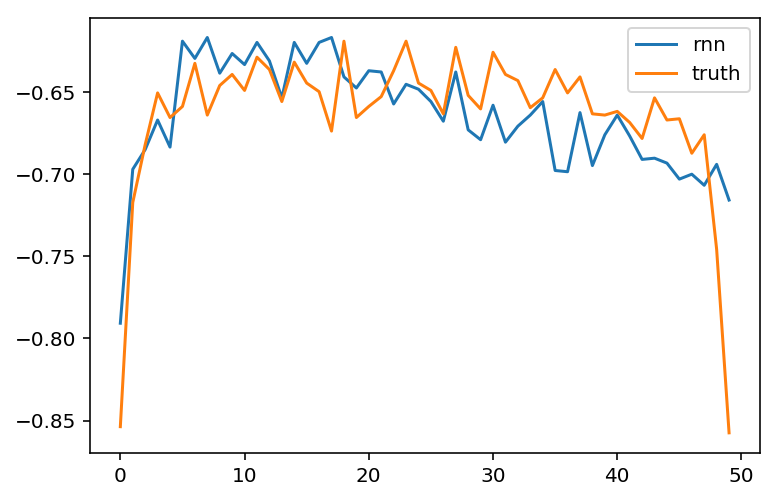

In [12]:
import numpy as np
import torch
from torch import optim
from pepinillo.dataloader import POVMData
from pepinillo.operators import Pauli4, Pauli
import _pickle as pkl


povm = Pauli4()
dataset = POVMData('../notebooks/data/TFIM_training_data.npz', povm)
dataset = POVMData(dataset.filename, dataset.povm_set, data=dataset.data[:50000])



samples = torch.cat([model.sample() for i in range(200)], dim=1) 
samples = samples.permute([1, 0, 2])
idsamples = np.ones((8000, n_qubits), dtype=np.long)
idsamples2 = np.ones((8000, n_qubits), dtype=np.long)

for i in range(8000):
    idsamples[i, :] = np.argmax(samples[i, :, :], axis=1)    
    idsamples2[i, :] = np.argmax(dataset.data[i, :, :], axis=1)
    

measure_X = [povm.rho(idsamples).measure(Pauli.X).on(i) for i in range(n_qubits)]
measure_X2 = [povm.rho(idsamples2).measure(Pauli.X).on(i) for i in range(n_qubits)]

import matplotlib.pyplot as plt

plt.plot(measure_X, label='rnn')
plt.plot(measure_X2, label='truth')
plt.legend()